In [17]:
import numpy as np
import bilby
import pylab as plt
from gwsnr import GWSNR as snr

In [6]:
# nsamples is use for fitting. default: nsamples=100
# nsamples with higher value will give better result.
# for BNS events nsamples can be kept low
# with defult bilby's psd
snr_ = snr(waveform_approximant = 'IMRPhenomXPHM', snr_type = 'inner_product')

Given: IMR waveform
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}


In [7]:
# Bilby
snr_.compute_bilby_snr_(mass_1=np.array([10.,50.,100.]), mass_2=np.array([10.,50.,100.]))

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 60.74it/s]


{'L1': array([128.04790782, 446.95912961, 739.7615249 ]),
 'H1': array([ 81.43759071, 284.26293939, 470.48325357]),
 'V1': array([ 37.90733753, 135.75613424, 227.17056196]),
 'opt_snr_net': array([156.41391919, 546.81588331, 905.65339387])}

In [8]:
# with inner_product
snr_.snr(mass_1=np.array([10.,50.,100.]), mass_2=np.array([10.,50.,100.]))

solving SNR with inner product


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 73.17it/s]


{'L1': array([128.04790782, 446.95912961, 739.7615249 ]),
 'H1': array([ 81.43759071, 284.26293939, 470.48325357]),
 'V1': array([ 37.90733753, 135.75613424, 227.17056196]),
 'opt_snr_net': array([156.41391919, 546.81588331, 905.65339387])}

In [11]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 100
chirp_mass = np.linspace(5,80,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)

bilby.core.utils.logger.disabled = True
prior_default = bilby.gw.prior.BBHPriorDict()
a_1 = prior_default["a_1"].sample(nsamples)
a_2 = prior_default["a_2"].sample(nsamples)
tilt_1 = prior_default["tilt_1"].sample(nsamples)
tilt_2 = prior_default["tilt_2"].sample(nsamples)
phi_12 = prior_default["phi_12"].sample(nsamples)
phi_jl = prior_default["phi_jl"].sample(nsamples)

In [13]:
# error might occur for mchirp>95., if f_min=20. 
bilby_ = snr_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec, a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, \
                                phi_12=phi_12, phi_jl=phi_jl)

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 187.08it/s]


In [21]:
mine_ = snr_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec, a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, \
                                phi_12=phi_12, phi_jl=phi_jl)

solving SNR with inner product


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 193.53it/s]


In [22]:
mtot_min=2.
mtot_max=439.6
idx = (total_mass<=mtot_min)&(total_mass>=mtot_max)
bilby_['opt_snr_net'][idx] = 0.

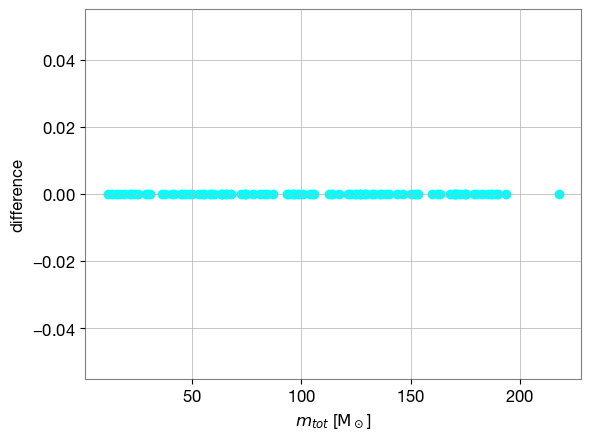

In [23]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()